In [1]:
import tensorflow as tf
import numpy as np
import pickle
import itertools

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_model(shape):
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.1))
    model.add(LSTM(200, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(shape[1]))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

def train_model(model, X, y, val_data, epochs=10, batch_size=50):
    history = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size)
    return history
    
def save(model, name):
    model_json = model.to_json()
    with open(name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + '.h5')

def load(name):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return model

In [3]:
def get_sonnets(filename):
    """ Returns entire txt file as string. """
    str = ""
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line.isdigit() == False and len(line) > 0:
                str += line.lower() + "\n"
    return str

In [4]:
file = 'data/shakespeare.txt'
sons = get_sonnets(file)

print ("# chars in txt: " + str(len(sons)))

# chars in txt: 93674


In [5]:
chars = set(sons) # get set of all characters
print(chars)
print ("# unique chars: " + str(len(chars)))

# create mapping of characters to unique ids
dic_char_to_id = dict((c, i) for i, c in enumerate(chars))
dic_id_to_char = dict((i, c) for i, c in enumerate(chars))

{'?', 't', 'z', '(', 'u', 'y', 'b', 'c', 'f', 'q', '\n', 'g', 'm', 'h', 'n', ':', ';', '.', ')', 'v', 'i', 'r', 's', 'e', 'l', 'k', 'd', 'w', 'j', 'x', '-', '!', 'o', 'p', 'a', "'", ' ', ','}
# unique chars: 38


In [6]:
# create input, output sequences

leng = 40
step_size = 2
seqs, nxt_char = [], []
# take all possible subsequences of 40 consecutive characters
for i in range(0, len(sons) - leng, step_size):
    seqs.append(sons[i: i + leng])
    nxt_char.append(sons[i + leng])
print("# seqs: ", len(seqs))

# seqs:  46817


In [7]:
# convert seqs to one-hot encoding
X = np.zeros((len(seqs), leng, len(chars)), dtype=np.bool)
y = np.zeros((len(seqs), len(chars)), dtype=np.bool)

for i, seq in enumerate(seqs):
    for j, char in enumerate(seq):
        X[i, j, dic_char_to_id[char]] = 1
    y[i, dic_char_to_id[nxt_char[i]]] = 1

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
model = get_model((leng, len(chars)))

In [10]:
history = train_model(model, x_train, y_train, (x_test, y_test))

Train on 31367 samples, validate on 15450 samples
Epoch 1/10
31367/31367 [==============================] - 219s 7ms/step - loss: 2.6876 - val_loss: 2.4708
Epoch 2/10
31367/31367 [==============================] - 378s 12ms/step - loss: 2.1907 - val_loss: 2.0997
Epoch 3/10
31367/31367 [==============================] - 420s 13ms/step - loss: 2.0052 - val_loss: 1.9979
Epoch 4/10
31367/31367 [==============================] - 27331s 871ms/step - loss: 1.8822 - val_loss: 1.8931
Epoch 5/10
31367/31367 [==============================] - 440s 14ms/step - loss: 1.7852 - val_loss: 1.8379
Epoch 6/10
31367/31367 [==============================] - 970s 31ms/step - loss: 1.7050 - val_loss: 1.8170
Epoch 7/10
31367/31367 [==============================] - 264s 8ms/step - loss: 1.6335 - val_loss: 1.7855
Epoch 8/10
31367/31367 [==============================] - 340s 11ms/step - loss: 1.5623 - val_loss: 1.7751
Epoch 9/10
31367/31367 [==============================] - 336s 11ms/step - loss: 1.4879 - val

In [11]:
save(model, 'models/Shakespeare_200units_10_50_0.1DROPOUT')

#150 units, 200 units, epochs, batch_size, dropout

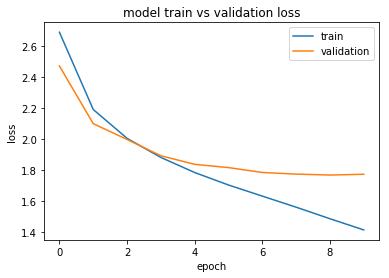

In [18]:
from matplotlib import pyplot

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig('visuals/Shakespeare_200units1_10_50_0.1DROPOUT_loss.png')
pyplot.show()

In [13]:
min(history.history['val_loss']) # 1.7592611852973024

1.7690014426376441

In [14]:
history.history['val_loss'].index(min(history.history['val_loss'])) # 10

8

In [15]:
with open('Shakespeare_200units_10_50_0.1DROPOUT_hist.pkl', 'wb') as f:
    pickle.dump(history, f)

In [16]:
def sample(preds, temperature = 1.0):
    ''' Helper function to sample an index from
    a probability array. Taken from StackOverflow/
    open source code on GitHub. '''

    preds = np.asarray(preds).astype('float')
    preds = np.log(preds) / temperature
    preds[preds == np.inf] = 0

    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return np.argmax(np.random.multinomial(1, preds, 1))

In [17]:
nchar = 800 # length of each line produced from preds
for temp in [1.5, 0.75, 0.25]:
    print( '\n' + '\n' + 'temperature = ' + str(temp) + '\n')
    
    line = 'shall i compare thee to a summer\'s day?\n'
    sentence = line
    
    for i in range(nchar):
        x = np.zeros((1, leng, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, dic_char_to_id[char]] = 1

        preds = model.predict(x, verbose=False)[0]
        nxt_char = dic_id_to_char[sample(preds, temp)]

        line += nxt_char
        sentence = sentence[1:] + nxt_char
        
    print(line)



temperature = 1.5

shall i compare thee to a summer's day?
keak's migirad still youdh shaploufit houlm,
haputed bul doth fyes cheact, spented shoo d? then'rie rid
eothem :im ixvestcengeo.
beth cabght weal, i cruentbre feamy swels,
but soaf in  hatherr, that thee of kepf'fin thie,
pyiins mage of misared my solf in thee,
voous dear shoud do suts couetion ste com,
ore,
ac goated so thou-girceaf aawio af lihereqshe,
will thee is stiffeepse were:
.o withou wht hi (cruestn commene, know,
verkax then to youb though toaw blswert,
fir with orn trmesuring, as thost, bear thee brear.
yet sam tim an ough aw desefti)f ever
loomh, by gleos 'ome, yie rommy sb'll all,
igpestiit, hish, to still hnetuse mork chance-bies:
ko if liw,siagai,sais getmer in less
with liker's qreet nee, bat grean that had:ullikey.
himiho lours cinst infautwince seargh last.
but loving yo


temperature = 0.75

shall i compare thee to a summer's day?
alt hat i rot love bear in this kis fierded,
and caen live in thee, my best 